<a href="https://colab.research.google.com/github/gabriellcortes/Suport-Vector-Machine/blob/main/Analise%20GTZAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdução

Support Vector Machine” (SVM) é um algoritmo de aprendizado de máquina supervisionado que pode ser usado para desafios de classificação ou regressão. Tendo em mente isso, esse trabalho tem como objetivo utilizar esse algoritmo para classificação de gêneros de musicas. 

Nesse contexto, escolheu o banco de dados [GTZAN](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification).
Este conta com uma coleção de 10 gêneros com 100 arquivos de áudio cada, todos com um comprimento de 30 segundos. 

Como esses arquivos de aúdios foram disponibilizados, tomei a liberdade de gerar meu próprio banco de dados e comparar com o banco de dados original.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.io.wavfile as wav
from tempfile import TemporaryFile
import IPython
import librosa #Biblioteca utilizada para tratamento de audio em python
import librosa.display
import sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
sns.set_style('whitegrid')

# Gerando meu próprio banco de dados.
Para fins de análise e comparação, eu decidi criar uma função que gerasse meu próprio banco de dados, dessa forma, poderei replicar qualquer música nesse algoritmo.

# Diferença entre os bancos de dados
O banco de dados original optou por registrar apenas a média e a variância de cada um dos aspectos espectrais, diferentemente disso, eu optei por registrar a média, variância, valor mínimo, valor máximo, mediana, 1° quartil e 3° quartil.


In [ ]:
def medidas_resumo(dict, array_obj, name):
    key_j = name + "_mean"
    dict[key_j] = np.ndarray.mean(array_obj)
    key_j = name + "_var"
    dict[key_j] = np.ndarray.var(array_obj)
    key_j = name + "_max"
    dict[key_j] = np.ndarray.max(array_obj) 
    key_j = name + "_min"
    dict[key_j] = np.ndarray.min(array_obj) 
    key_j = name + "_median"
    dict[key_j] = np.median(array_obj)
    key_j = name + "_qt1"
    dict[key_j] = np.quantile(array_obj, 0.25)
    key_j = name + "_qt2"
    dict[key_j] = np.quantile(array_obj, 0.75)
    return(dict)

def Feature_extraction(directory, folder, file):
    #print(file, flush = True)
    # Coletando características espectrais 
    signal, sample_rate = librosa.load(f'{directory+"/"+folder+"/"+file}')
    ch = librosa.feature.chroma_stft(y=signal, sr=sample_rate)
    rms = librosa.feature.rms(y=signal)
    sp_cen = librosa.feature.spectral_centroid(y=signal, sr=sample_rate)
    sp_band = librosa.feature.spectral_bandwidth(y=signal, sr=sample_rate)
    sp_roll = librosa.feature.spectral_rolloff(y=signal, sr=sample_rate)
    sp_zero = librosa.feature.zero_crossing_rate(y=signal)
    harmonic = librosa.effects.harmonic(y = signal)
    
    C = np.abs(librosa.cqt(y = signal, sr=sample_rate, fmin=librosa.note_to_hz('A1')))
    freqs = librosa.cqt_frequencies(C.shape[0],
                                    fmin=librosa.note_to_hz('A1'))
    perceptual = librosa.perceptual_weighting(C**2,
                                                freqs,
                                                ref=np.max)
    tempo = librosa.beat.tempo(y=signal,sr=sample_rate)
    mfc = librosa.feature.mfcc(y=signal,sr=sample_rate)

    row = { 
    'filename':file, 
    'tempo':tempo[0]
    }
    
    row = medidas_resumo(row, ch,"chroma_stft" )
    row = medidas_resumo(row, rms,"rms_mean" )
    row = medidas_resumo(row, sp_cen,"spectral_centroid_mean" )
    row = medidas_resumo(row, sp_band,"spectral_bandwidth_mean" )
    row = medidas_resumo(row, sp_roll,"rolloff_mean" )
    row = medidas_resumo(row, sp_zero,"zero_crossing_rate_mean" ) 
    row = medidas_resumo(row, harmonic,"harmony_mean" )
    row = medidas_resumo(row, perceptual,"perceptr_mean" )
    
    for j in range(len(mfc)):
        key_j = 'mfcc_{}'.format(j) 
        row = medidas_resumo(row, mfc[j],key_j )
    
    row['label']= folder
    return(row)

In [ ]:
dataframe = False
directory = "Data/genres_original"
f= open("my.dat",'wb')
lista_dir = []
for folder in os.listdir(directory):
    print(folder)
    for file in os.listdir(os.path.join(directory, folder)):
        row = Feature_extraction(directory, folder, file)
        if dataframe == False:
            dataframe = True
            dados = pd.DataFrame(row, index=[0])
        else:
            dados = pd.concat([dados, pd.DataFrame(row, index=[0])], ignore_index=True)
dados.to_csv('Data/dados.csv', index=False) #Salvando

# Comparando os dois bancos




In [2]:
data_GTZAN = pd.read_csv('https://raw.githubusercontent.com/gabriellcortes/Suport-Vector-Machine/main/features_30_sec.csv') # Original
data_GTZAN = data_GTZAN.loc[:, data_GTZAN.columns != 'filename']
data = pd.read_csv('https://raw.githubusercontent.com/gabriellcortes/Suport-Vector-Machine/main/dados.csv') # Novo 
data = data.loc[:, data.columns != 'filename']

In [5]:
data.head() 

,tempo,chroma_stft_mean,chroma_stft_var,chroma_stft_max,chroma_stft_min,chroma_stft_median,chroma_stft_qt1,chroma_stft_qt2,rms_mean_mean,rms_mean_var,...,mfcc_mean_18_qt1,mfcc_mean_18_qt2,mfcc_mean_19_mean,mfcc_mean_19_var,mfcc_mean_19_max,mfcc_mean_19_min,mfcc_mean_19_median,mfcc_mean_19_qt1,mfcc_mean_19_qt2,label
0,123.046875,0.350129,0.088772,1.0,0.001883,0.254469,0.112016,0.509971,0.130184,0.002828,...,-7.189630,1.837867,1.222467,46.941350,32.866340,-23.219631,0.941804,-3.579244,5.497650,blues
1,107.666016,0.340849,0.094976,1.0,0.001808,0.232328,0.089450,0.521089,0.095908,0.002373,...,-4.961407,4.222943,0.530644,45.788700,27.740532,-17.131062,0.290101,-4.288013,4.693344,blues
2,161.499023,0.363538,0.085257,1.0,0.003168,0.275098,0.130408,0.520045,0.175473,0.002751,...,-8.082528,0.335357,-2.238128,30.653150,16.524359,-29.785423,-2.112655,-5.789953,1.266118,blues
3,172.265625,0.404854,0.093999,1.0,0.005738,0.320005,0.145432,0.622788,0.141040,0.006348,...,-4.728713,3.534681,-3.405046,31.965254,16.595015,-21.426252,-3.723261,-6.868982,-0.029808,blues
4,135.999178,0.308526,0.087843,1.0,0.001347,0.201387,0.084953,0.429789,0.091501,0.002305,...,-9.217802,0.448059,-11.704385,55.190254,4.889852,-41.730530,-10.748793,-15.777891,-6.449556,blues


In [6]:
data_GTZAN.head() 

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


O Banco de dados original possui 1000 linhas x 59 colunas e o novo banco de dados possui 999 linhas e 198 colunas, um aumento de 139 colunas e redução de 1 música (o arquivo estava corrompido).

# Analise dos dados

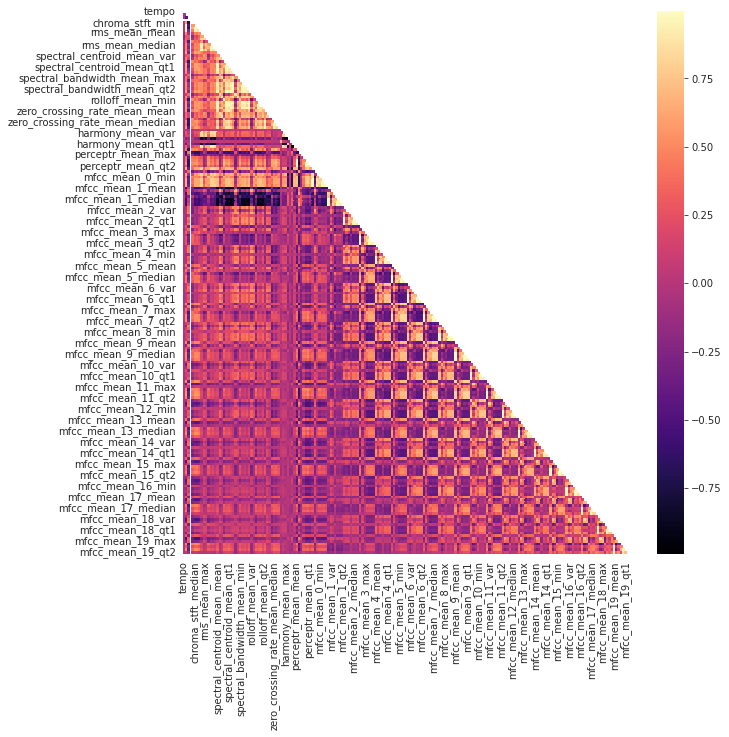

In [18]:
correlation=data.corr()
mask=np.zeros_like(correlation)
mask[np.triu_indices_from(mask)]=True
plt.subplots(figsize=(10,10))
sns.heatmap(correlation,mask=mask,cmap='magma')
plt.show()

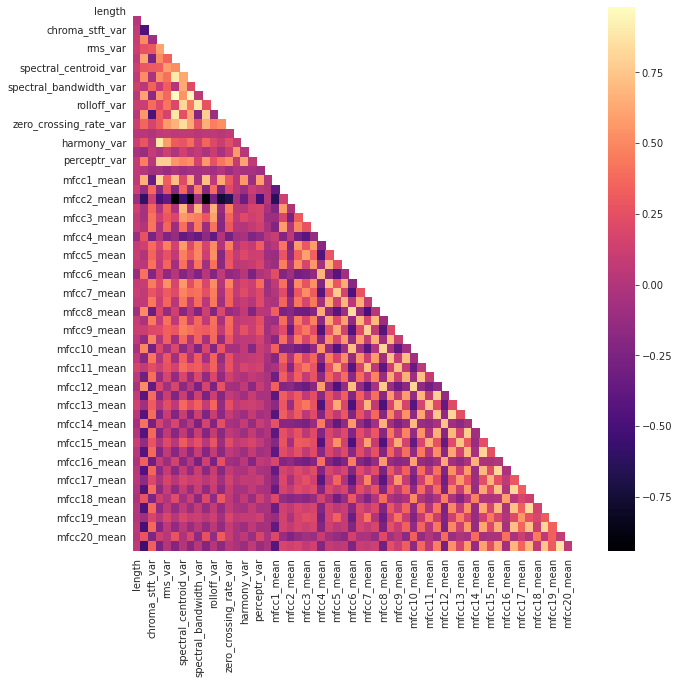

In [19]:
correlation=data_GTZAN.corr()
mask=np.zeros_like(correlation)
mask[np.triu_indices_from(mask)]=True
plt.subplots(figsize=(10,10))
sns.heatmap(correlation,mask=mask,cmap='magma')
plt.show()

In [16]:
data['label'].unique()

array(['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
       'metal', 'pop', 'reggae', 'rock'], dtype=object)

# Descobrindo qual banco de dados está melhor

Para dar continuidade as análises, foi realizado uma amostra de 100 acuracias do algoritmo de svm para definir qual banco de dados obtem o melhor resultado. Após as simulações, utilizou-se de um boxplot para comparar os resultados. 

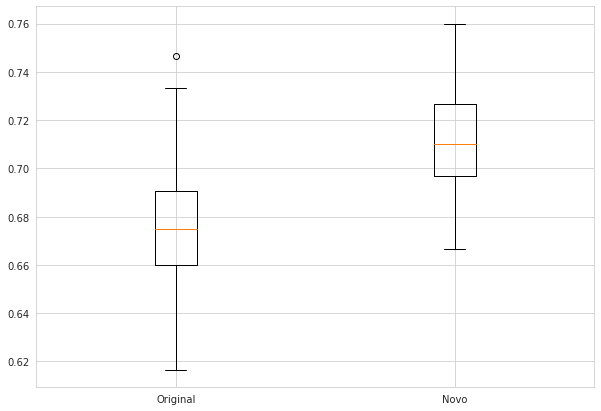

In [45]:
def model_assess(model, title = "Default", acurracy_list = False):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return round(accuracy_score(y_test, preds), 5)

temp = []
acuracias = {}

a = 1
for dataframe in [data_GTZAN,data]:
    # NOVO
    df = dataframe
    df = df.loc[:, df.columns != 'filename']
    y = df['label'] # Selecionando a varíavel resposta
    X = df.loc[:, df.columns != 'label' ]# Separando das demais
    # Normalizando
    cols = X.columns
    min_max_scaler = preprocessing.MinMaxScaler()
    np_scaled = min_max_scaler.fit_transform(X)
    X = pd.DataFrame(np_scaled, columns = cols)
    temp = []
    for j in range(100):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        svm = SVC(decision_function_shape="ovo")
        temp.append(model_assess(svm, "Support Vector Machine"))
        
    acuracias[str(a)] = temp
    a = a + 1
acuracias = pd.DataFrame(acuracias)

# Um boxplot para ver as acurácias     
fig = plt.figure(figsize =(10, 7))
plt.boxplot( x = acuracias.transpose(), labels = ["Original","Novo"])
plt.show()

De acordo com o boxplot, nota-se que o banco de dados novo obteve os melhores resultados, portanto, seguiremos utilizando ele.

# Preparando o banco de dados 
Para as análises seguintes será necessário normalizar os dados e separar as variáveis explicativas e a variável resposta.

In [46]:
y = data['label'] # Selecionando a varíavel resposta
X = data.loc[:, data.columns != 'label' ]# Separando das demais

# Normalizando
cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)

# Avaliando o melhor kernel para SVM

In [84]:
def model_assess(model, title = "Default", acurracy_list = False):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    if acurracy_list == False:
      return round(accuracy_score(y_test, preds), 4)
    else:
      return print(title, round(accuracy_score(y_test, preds), 4)*100, '% \n')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

for kernel_i in ["linear", "poly", "rbf", "sigmoid"] :
    svm = SVC(decision_function_shape="ovo", kernel=kernel_i)
    model_assess(svm, ("Support Vector Machine - "+kernel_i),acurracy_list = True)

Support Vector Machine - linear 79.2 % 

Support Vector Machine - poly 73.6 % 

Support Vector Machine - rbf 71.6 % 

Support Vector Machine - sigmoid 8.0 % 



Nota-se que o kernel linear se adaptou melhor para o banco de dados.

# PCA - Avaliando o número de componentes principais

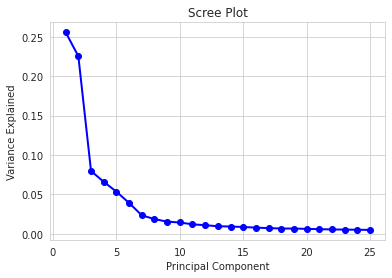

In [91]:
my_model = PCA(n_components=25)
my_model.fit_transform(X)
variancia_explicada = my_model.explained_variance_ratio_
PC_values = np.arange(my_model.n_components_) + 1

plt.plot(PC_values, variancia_explicada, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

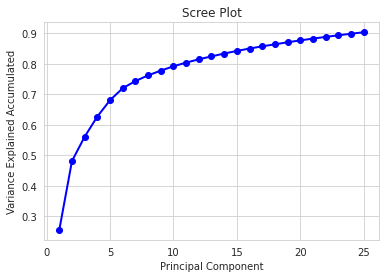

In [92]:
plt.plot(PC_values, variancia_explicada.cumsum(), 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained Accumulated')
plt.show()

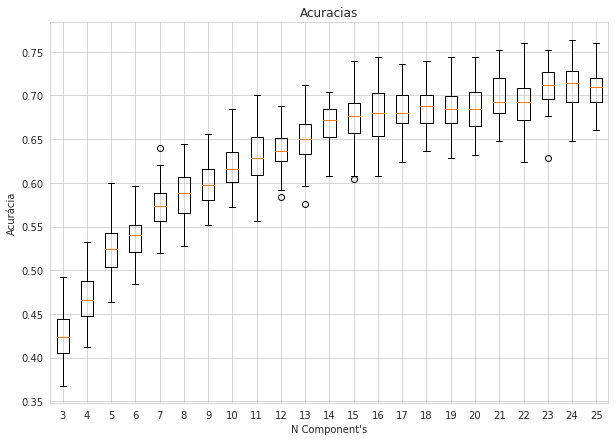

In [104]:
# Support Vector Machine
svm = SVC(decision_function_shape="ovo", kernel='linear')
acuracias = {}

for n_componentes in range(3,26):
    modelo = PCA(n_components=n_componentes)
    modelo = modelo.fit_transform(X)
    temp = []
    while len(temp) != 50:  
        X_train, X_test, y_train, y_test = train_test_split(modelo, y, test_size=0.25)
        temp.append(model_assess(svm, "Support Vector Machine"))
    acuracias[str(n_componentes)] = temp

acuracias = pd.DataFrame(acuracias)
fig = plt.figure(figsize =(10, 7))
plt.boxplot( acuracias.transpose(), labels = acuracias.keys())
plt.title('Acuracias')
plt.xlabel("N Component's")
plt.ylabel('Acurácia')
plt.show()

Observa-se que o modelo ganha uma quantidade consideravel de acurácia conforme aumenta o número de componentes principais, levando em consideração que o banco de dados original possui 198 colunas, optou-se por selecionar o número de componentes que atingisse a média maior que 70%, dessa forma, selecionou-se 23 componentes principais, levando a uma redução de 88%.

# Treinando os modelos - 23 Componentes principais

In [108]:
modelo = PCA(n_components=23)
modelo = modelo.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(modelo, y, test_size=0.25)


# Naive Bayes
nb = GaussianNB()
model_assess(nb, "Naive Bayes", acurracy_list = True)

# Stochastic Gradient Descent
sgd = SGDClassifier(max_iter=5000, random_state=0)
model_assess(sgd, "Stochastic Gradient Descent", acurracy_list = True)

# KNN
knn = KNeighborsClassifier(n_neighbors=19)
model_assess(knn, "KNN", acurracy_list = True)

# Decission trees
tree = DecisionTreeClassifier()
model_assess(tree, "Decission trees", acurracy_list = True)

# Random Forest
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
model_assess(rforest, "Random Forest", acurracy_list = True)


# Support Vector Machine
svm = SVC(decision_function_shape="ovo", kernel ="linear")
model_assess(svm, "Support Vector Machine", acurracy_list = True)

Naive Bayes 64.4 % 

Stochastic Gradient Descent 63.2 % 

KNN 66.4 % 

Decission trees 40.0 % 

Random Forest 69.6 % 

Support Vector Machine 68.4 % 



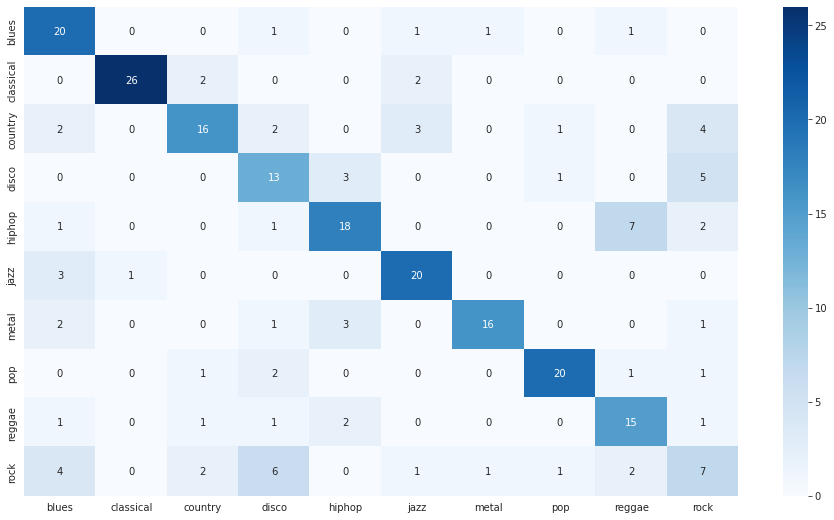

In [109]:
svm = SVC(decision_function_shape="ovo", kernel='linear')
svm.fit(X_train, y_train)
preds = svm.predict(X_test)

# Confusion Matrix
confusion_matr = confusion_matrix(y_test, preds) #normalize = 'true'
plt.figure(figsize = (16, 9))
sns.heatmap(confusion_matr, cmap="Blues", annot=True, 
            xticklabels = np.unique(y_test),
           yticklabels = np.unique(y_test));
plt.savefig("conf matrix")

# Treinando os modelos - Dados completos
Como o banco de dados possui apenas 999 observações, vou realizar o treinamento dos modelos para o banco de dados completo também.

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Naive Bayes
nb = GaussianNB()
model_assess(nb, "Naive Bayes", acurracy_list = True)

# Stochastic Gradient Descent
sgd = SGDClassifier(max_iter=5000, random_state=0)
model_assess(sgd, "Stochastic Gradient Descent", acurracy_list = True)

# KNN
knn = KNeighborsClassifier(n_neighbors=19)
model_assess(knn, "KNN", acurracy_list = True)

# Decission trees
tree = DecisionTreeClassifier()
model_assess(tree, "Decission trees", acurracy_list = True)

# Random Forest
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
model_assess(rforest, "Random Forest", acurracy_list = True)


# Support Vector Machine
svm = SVC(decision_function_shape="ovo", kernel ="linear")
model_assess(svm, "Support Vector Machine", acurracy_list = True)

Naive Bayes 51.2 % 

Stochastic Gradient Descent 56.8 % 

KNN 64.8 % 

Decission trees 51.2 % 

Random Forest 70.8 % 

Support Vector Machine 78.0 % 



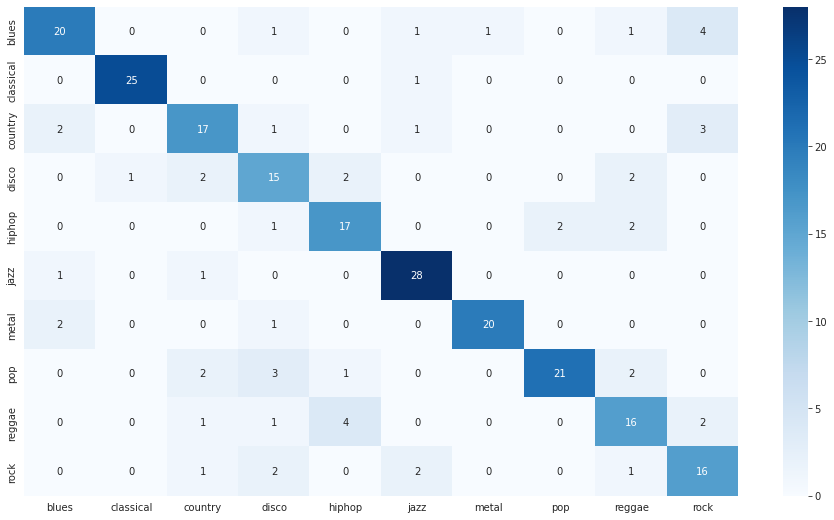

In [111]:
svm = SVC(decision_function_shape="ovo", kernel='linear')
svm.fit(X_train, y_train)
preds = svm.predict(X_test)

# Confusion Matrix
confusion_matr = confusion_matrix(y_test, preds) #normalize = 'true'
plt.figure(figsize = (16, 9))
sns.heatmap(confusion_matr, cmap="Blues", annot=True, 
            xticklabels = np.unique(y_test),
           yticklabels = np.unique(y_test));
plt.savefig("conf matrix")

# Conclusão

Observa-se que o banco de dados original ganhou aproximadamente 10% de acuracia em relação ao banco de dados com as 23 componentes principais. Além disso, em ambos os casos o algoritmo de SVM obteve melhores resultados do que os demais algoritmos. 